#Import and load data

In [1]:
import os

In [2]:
#Start by connecting gdrive into the google colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
os.chdir('/content/gdrive/MyDrive/Projet_NLP/data')

In [ ]:
# not needed anymore
#!unzip fnc-1-master.zip

Archive:  fnc-1-master.zip
29d473af2d15278f0464d5e41e4cbe7eb58231f2
   creating: fnc-1-master/
  inflating: fnc-1-master/README.md  
  inflating: fnc-1-master/competition_test_bodies.csv  
  inflating: fnc-1-master/competition_test_stances.csv  
  inflating: fnc-1-master/competition_test_stances_unlabeled.csv  
  inflating: fnc-1-master/scorer.py  
  inflating: fnc-1-master/test_bodies.csv  
  inflating: fnc-1-master/test_stances_unlabeled.csv  
  inflating: fnc-1-master/train_bodies.csv  
  inflating: fnc-1-master/train_stances.csv  
  inflating: fnc-1-master/train_stances.random.csv  


In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import numpy as np
import random
import tensorflow as tf
import tensorflow.keras as keras
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt

Load data

In [5]:
train_bodies = pd.read_csv('train_bodies.csv') # BodyID, Body (text)
train_stances = pd.read_csv('train_stances.csv') # Headline, BodyID, Stance (label)

test_bodies = pd.read_csv('competition_test_bodies.csv') # BodyID, Body
test_stances = pd.read_csv('competition_test_stances.csv') # Headline, BodyID, Stance

##data exploration

no missing data :)

In [ ]:
print(train_bodies.info())
print()
print(train_stances.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1683 entries, 0 to 1682
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Body ID      1683 non-null   int64 
 1   articleBody  1683 non-null   object
dtypes: int64(1), object(1)
memory usage: 26.4+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49972 entries, 0 to 49971
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Headline  49972 non-null  object
 1   Body ID   49972 non-null  int64 
 2   Stance    49972 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB
None


Data unbalanced (data augmentation ? but not allowed in official kaggle competition)


In [ ]:
sum([train_stances.Stance=='agree']).sum()

3678

<Axes: title={'center': 'Dataset Repartition'}, ylabel='Stance'>

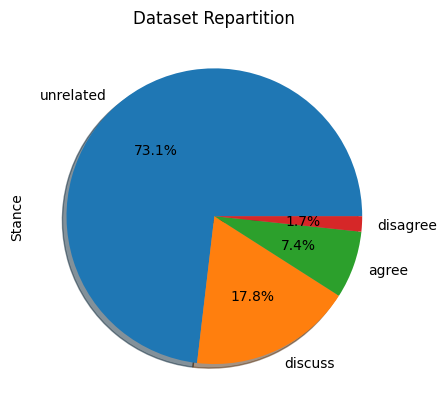

In [ ]:
train_stances["Stance"].value_counts(normalize=True).plot(kind='pie',autopct='%1.1f%%', title='Dataset Repartition',
                                                      shadow=True)

#Data preprocessing

In [ ]:
train_stances

,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,unrelated
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated
4,Spider burrowed through tourist's stomach and ...,1923,disagree
...,...,...,...
49967,Urgent: The Leader of ISIL 'Abu Bakr al-Baghda...,1681,unrelated
49968,Brian Williams slams social media for speculat...,2419,unrelated
49969,Mexico Says Missing Students Not Found In Firs...,1156,agree
49970,US Lawmaker: Ten ISIS Fighters Have Been Appre...,1012,discuss


In [ ]:
train_bodies

,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...
...,...,...
1678,2528,Intelligence agencies hunting for identity of ...
1679,2529,"While Daleks ""know no fear"" and ""must not fear..."
1680,2530,More than 200 schoolgirls were kidnapped in Ap...
1681,2531,A Guantanamo Bay prisoner released last year a...


In [6]:
cat = pd.Categorical(train_stances['Headline'])
train_headlines = pd.Series(cat.categories,name='headline')
train_stances['head id'] = cat.codes
train_stances = train_stances.drop(columns='Headline')

cat = pd.Categorical(train_stances['Body ID'])
train_bodies = pd.Series([train_bodies['articleBody'][(train_bodies['Body ID'] == i)].values[0] for i in cat.categories], name='article body')
train_stances['body id'] = cat.codes
train_stances = train_stances.drop(columns='Body ID')

cat = pd.Categorical(train_stances['Stance'])
stances = pd.Series(cat.categories,name='stance')
train_stances['stance'] = cat.codes
train_stances = train_stances.drop(columns='Stance')

cat = pd.Categorical(test_stances['Headline'])
test_headlines = pd.Series(cat.categories,name='headline')
test_stances['head id'] = cat.codes
test_stances = test_stances.drop(columns='Headline')

cat = pd.Categorical(test_stances['Body ID'])
test_bodies = pd.Series([test_bodies['articleBody'][(test_bodies['Body ID'] == i)].values[0] for i in cat.categories], name='article body')
test_stances['body id'] = cat.codes
test_stances = test_stances.drop(columns='Body ID')

cat = pd.Categorical(test_stances['Stance'], categories = stances)
test_stances['stance'] = cat.codes
test_stances = test_stances.drop(columns='Stance')


In [ ]:
test_stances

,head id,body id,stance
0,236,675,3
1,186,516,3
2,36,1,3
3,872,607,3
4,114,10,3
...,...,...,...
25408,758,899,0
25409,758,900,2
25410,758,901,1
25411,758,902,1


create vectorizers and BOW and TF arrays for train set

In [7]:
lim_unigram = 5000
bow_vectorizer = CountVectorizer(max_features=lim_unigram, stop_words=list(ENGLISH_STOP_WORDS)) #possible to change stop words
bow = bow_vectorizer.fit_transform(list(train_headlines) + list(train_bodies))  # Train set only

tfreq_vectorizer = TfidfTransformer(use_idf=False).fit(bow)
tfreq = tfreq_vectorizer.transform(bow).toarray()  # Train set only

tfidf_vectorizer = TfidfVectorizer(max_features=lim_unigram, stop_words=list(ENGLISH_STOP_WORDS)).\
    fit(list(train_headlines) + list(train_bodies) + \
        list(test_headlines)  + list(test_bodies)
        )  # Train and test sets

encode headlines and bodies : 
* the TF representation of the headline
* the TF representation of the body
* the normalised TFIDF vectors’ cosine similarity

In [8]:
#TF representation
bow = bow_vectorizer.transform(list(train_headlines)).toarray()
head_vect_train = tfreq_vectorizer.transform(bow).toarray()
bow = bow_vectorizer.transform(list(test_headlines)).toarray()
head_vect_test = tfreq_vectorizer.transform(bow).toarray()
bow =  bow_vectorizer.transform(list(train_bodies)).toarray()
body_vect_train = tfreq_vectorizer.transform(bow).toarray()
bow =  bow_vectorizer.transform(list(test_bodies)).toarray()
body_vect_test = tfreq_vectorizer.transform(bow).toarray()

#normalized TFIDF vectors' cosine similarity
head_tfidf_train = tfidf_vectorizer.transform(list(train_headlines)).toarray()
head_tfidf_test = tfidf_vectorizer.transform(list(test_headlines)).toarray()
body_tfidf_train = tfidf_vectorizer.transform(list(train_bodies)).toarray()
body_tfidf_test = tfidf_vectorizer.transform(list(test_bodies)).toarray()

cos_sim = lambda i : cosine_similarity(
    head_tfidf_train[train_stances['head id'][i]].reshape(1,-1),
    body_tfidf_train[train_stances['body id'][i]].reshape(1,-1)).squeeze()
tfidf_cos_train = np.array([cos_sim(i) for i in range(len(train_stances))])

cos_sim = lambda i : cosine_similarity(
    head_tfidf_test[test_stances['head id'][i]].reshape(1,-1),
    body_tfidf_test[test_stances['body id'][i]].reshape(1,-1)).squeeze()
tfidf_cos_test = np.array([cos_sim(i) for i in range(len(test_stances))])

concatenate representations to compute train and test sets

In [9]:
train_set = np.c_[head_vect_train[train_stances['head id']],
                  body_vect_train[train_stances['body id']],
                  tfidf_cos_train]

test_set = np.c_[head_vect_test[test_stances['head id']],
                 body_vect_test[test_stances['body id']],
                 tfidf_cos_test]

In [10]:
del tfreq, body_vect_train, body_tfidf_train, \
    head_tfidf_train, head_vect_train, bow, \
    body_vect_test, body_tfidf_test, head_vect_test, \
    head_tfidf_test


#Model UCLMR :  MLP with only one hidden layer (3rd place of the competition)

parameters

In [ ]:
display_summary = True
target_size = 4 # 4 different classes, (stances)
hidden_size = 100 # hidden layer width
train_keep_prob = 0.6 # for dropouts
l2_reg = 0.00001 # regularization parameter
learning_rate = 0.01 # learning rate
clip_ratio = 5 # clip ratio for the gradient norm clipping
batch_size_train = 512 
epochs = 90 # number of epochs for training
weight_decay = 0.0001

UCLMR solution : only 1 hidden layer
https://arxiv.org/pdf/1707.03264.pdf 


In [ ]:
feature_size = train_set.shape[1]
regul = keras.regularizers.l2(l2_reg)

input = keras.Input(shape = (feature_size,), name='features')
hidden = keras.layers.Dense(hidden_size, activation='relu',kernel_regularizer=regul)(input)
hidden = keras.layers.Dropout(1-train_keep_prob, name = 'hidden')(hidden)
output = keras.layers.Dense(target_size,kernel_regularizer=regul)(hidden)
output = keras.layers.Dropout(1-train_keep_prob, name = 'output')(output)
softmax = keras.layers.Activation('softmax', name='classifier')(output)

model = keras.Model(inputs=input, outputs=softmax)

loss = keras.losses.SparseCategoricalCrossentropy(from_logits='True')
model.compile(optimizer = keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=clip_ratio, weight_decay=weight_decay), loss=loss)

if display_summary : model.summary ()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 features (InputLayer)       [(None, 10001)]           0         
                                                                 
 dense (Dense)               (None, 100)               1000200   
                                                                 
 hidden (Dropout)            (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 404       
                                                                 
 output (Dropout)            (None, 4)                 0         
                                                                 
 classifier (Activation)     (None, 4)                 0         
                                                                 
Total params: 1,000,604
Trainable params: 1,000,604
Non-train

##Training

In [ ]:
history = model.fit(train_set, train_stances['stance'].to_numpy(),batch_size_train,epochs,validation_data=(test_set, test_stances['stance'].to_numpy()))

Epoch 1/90


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


98/98 [==============================] - 11s 98ms/step - loss: 0.6910 - val_loss: 0.4575
Epoch 2/90
98/98 [==============================] - 10s 102ms/step - loss: 0.4729 - val_loss: 0.4420
Epoch 3/90
98/98 [==============================] - 10s 100ms/step - loss: 0.4420 - val_loss: 0.4218
Epoch 4/90
98/98 [==============================] - 8s 82ms/step - loss: 0.4257 - val_loss: 0.4279
Epoch 5/90
98/98 [==============================] - 10s 101ms/step - loss: 0.4241 - val_loss: 0.4126
Epoch 6/90
98/98 [==============================] - 9s 95ms/step - loss: 0.4141 - val_loss: 0.4249
Epoch 7/90
98/98 [==============================] - 8s 86ms/step - loss: 0.4128 - val_loss: 0.4133
Epoch 8/90
98/98 [==============================] - 10s 100ms/step - loss: 0.4106 - val_loss: 0.4182
Epoch 9/90
98/98 [==============================] - 8s 85ms/step - loss: 0.4069 - val_loss: 0.4207
Epoch 10/90
98/98 [==============================] - 10s 99ms/step - loss: 0.4035 - val_loss: 0.4283
Epoch 11/9

save the model

In [ ]:
model.save('/content/gdrive/MyDrive/Projet_NLP/models/my_model_UCLMR_wd')

## Results

In [11]:
def metric (X,Y, unrelated_index = 3) :
    lvl1 = 0.25 * ((X == unrelated_index ) == (Y == unrelated_index)).sum()
    lvl2 = 0.75 * ((X != unrelated_index) & (X == Y)).sum()
    return lvl1 + lvl2

In [ ]:
res = metric(model.predict(test_set).argmax(1), test_stances['stance'], 3)
print(f'for this model the score is {res}, the baseline score was 9521.5')

795/795 [==============================] - 3s 4ms/step
for this model the score is 9544.0, the baseline score was 9521.5


In [ ]:
#to call saved model 
new_model = tf.keras.models.load_model('../models/my_model_UCLMR')
new_res = metric(new_model.predict(test_set).argmax(1), test_stances['stance'], 3)
print(f'for this model the score is {new_res}, the baseline score was 9521.5')

795/795 [==============================] - 4s 5ms/step
for this model the score is 9502.25, the baseline score was 9521.5


In [12]:
#to call saved model with weight decay
model = tf.keras.models.load_model('../models/my_model_UCLMR_wd')
res = metric(model.predict(test_set).argmax(1), test_stances['stance'], 3)
print(f'for this model the score is {res}, the baseline score was 9521.5')

795/795 [==============================] - 6s 7ms/step
for this model the score is 9544.0, the baseline score was 9521.5


F1-score evaluation

In [16]:
from sklearn.metrics import f1_score
y_true = test_stances['stance']
y_predicted = model.predict(test_set).argmax(1)
f1_macro = f1_score(y_true, y_predicted, average='macro')
f1_micro = f1_score(y_true, y_predicted, average='micro')
f1_weighted = f1_score(y_true, y_predicted, average='weighted')
#f1_classwise = f1_score(y_true, y_predicted, average=None, labels=['agree', 'disagree', 'discuss', 'unrelated'])
f1_classwise = f1_score(y_true, y_predicted, average=None, labels=[0, 1, 2, 3])

resultstring = "F1 macro: {:.3f}".format(f1_macro*100) + "% \n"
resultstring += "F1 micro: {:.3f}".format(f1_micro*100) + "% \n"
resultstring += "F1 weighted: {:.3f}".format(f1_weighted*100) + "% \n"
resultstring += "F1 agree: {:.3f}".format(f1_classwise[0]*100) + "% \n"
resultstring += "F1 disagree: {:.3f}".format(f1_classwise[1]*100) + "% \n"
resultstring += "F1 discuss: {:.3f}".format(f1_classwise[2]*100) + "% \n"
resultstring += "F1 unrelated: {:.3f}".format(f1_classwise[3]*100) + "% \n"

print(resultstring)

795/795 [==============================] - 2s 3ms/step
F1 macro: 55.832% 
F1 micro: 88.156% 
F1 weighted: 87.069% 
F1 agree: 47.355% 
F1 disagree: 3.862% 
F1 discuss: 74.770% 
F1 unrelated: 97.340% 



Confusion matrix

In [ ]:
class estimator:
  _estimator_type = ''
  classes_=[]
  def __init__(self, model, classes):
    self.model = model
    self._estimator_type = 'classifier'
    self.classes_ = classes
  def predict(self, X):
    y_prob= self.model.predict(X)
    y_pred = y_prob.argmax(axis=1)
    return y_pred

classifier = estimator(model, [0,1,2,3])

795/795 [==============================] - 3s 4ms/step


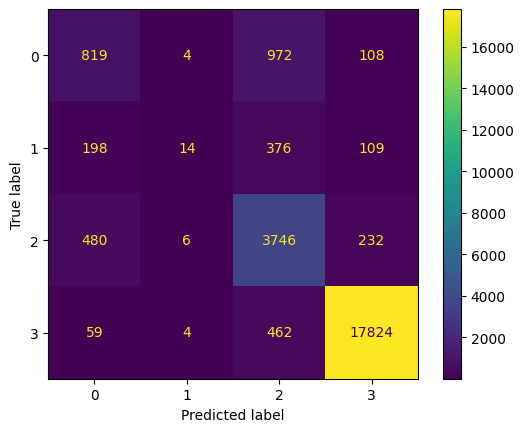

In [ ]:
predictions = model.predict(test_set).argmax(1)
confusion_matrix(test_stances['stance'], predictions)
disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
        test_set,
        test_stances['stance']
    )

Labels :
* 0 -> agree
* 1 -> disagree
* 2 -> discuss
* 3 -> unrelated

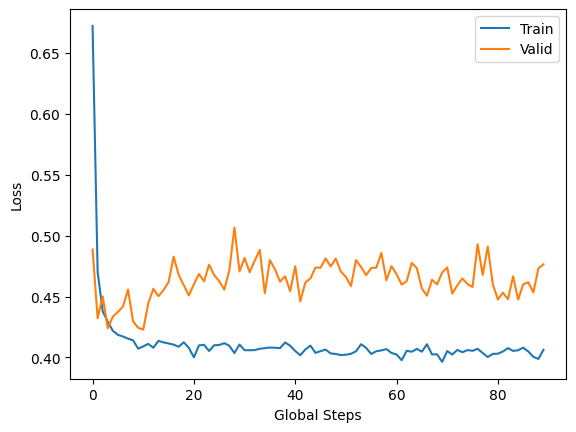

In [ ]:
train_loss_list = history.history['loss']
valid_loss_list = history.history['val_loss']
global_steps_list = list(range(len(train_loss_list)))

plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 